#### 1: Dataset anaylsis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import numpy as np
from PIL import Image
from collections import Counter

Data_storage = r'/content/drive/MyDrive/Università/ETH/DL/DL Project/Code/Small_brats_sample/BraTS2021_train/Flair'
files = os.listdir(Data_storage)
print('The dataset contains {} images'.format(len(files)))

image_shapes = []

# Loop through all files to gather image shapes
for file in files:
    file_path = os.path.join(Data_storage, file)
    try:
        with Image.open(file_path) as img:
            image_shapes.append(img.size)  # img.size returns (width, height)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

## SHAPES
# Analyze the shapes
shape_counter = Counter(image_shapes)

# Check if all images have the same shape
if len(shape_counter) == 1:
    print(f"The images in the dataset have shape: {list(shape_counter.keys())[0]}")
else:
    print("Images have different shapes. Distribution of shapes:")
    for shape, count in shape_counter.items():
        print(f"Shape {shape}: {count} images")

## INTENSITY RANGES
# Initialize variables to store the min and max pixel values across all images
global_min = float('inf')
global_max = float('-inf')
pixel_ranges = []  # To store (min, max) for each image

# Loop through all files to analyze pixel value ranges
for file in files:
    file_path = os.path.join(Data_storage, file)
    try:
        # Open the image and convert to a numpy array
        with Image.open(file_path) as img:
            img_array = np.array(img)
            img_min = img_array.min()
            img_max = img_array.max()
            pixel_ranges.append((img_min, img_max))

            # Update global min and max
            global_min = min(global_min, img_min)
            global_max = max(global_max, img_max)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Print the global min and max pixel values
print(f"The global pixel value range across all images: min={global_min}, max={global_max}")

# If you want to analyze the distribution of ranges
unique_ranges = {}
for min_val, max_val in pixel_ranges:
    unique_ranges[(min_val, max_val)] = unique_ranges.get((min_val, max_val), 0) + 1

print("\nDistribution of pixel value ranges across images:")
for (min_val, max_val), count in unique_ranges.items():
    print(f"Range ({min_val}, {max_val}): {count} images")

The dataset contains 11 images
The images in the dataset have shape: (512, 512)
The global pixel value range across all images: min=0, max=255

Distribution of pixel value ranges across images:
Range (0, 255): 5 images
Range (0, 250): 1 images
Range (0, 254): 3 images
Range (0, 252): 1 images
Range (0, 253): 1 images


#### 2: Dataset preprocessing
Analysing what happens online just before training
Fist, mount drive

In [17]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [19]:
from diffusers import StableDiffusionPipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id)
tokenizer = pipe.tokenizer

df = pd.read_csv(r'/content/drive/MyDrive/Università/ETH/DL/DL Project/Code/Small_brats_sample/BraTS2021_train/metadata.csv')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
# Make sure this corresponds to the class used in the main code
class ImageDataset(Dataset):
    def __init__(self, root_dir, df, tokenizer, size = 224, center_crop = True):
        self.root_dir = root_dir
        self.files = df['File_name'].tolist()
        self.findings = df['text'].tolist()
        self.tokenizer = tokenizer
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        example = {}
        instance_image = Image.open(
            os.path.join(self.root_dir, self.files[idx])
        ).convert("RGB")

        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.findings[idx],
            truncation=True,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        return example


In [27]:
# create image dataset
ds = ImageDataset(
    root_dir=Data_storage,
    df=df,
    tokenizer=tokenizer,
)

Let's analyise the composition of the dataset, so how many cases we have!

In [44]:
class_definitions = {
    'healthy_class': 'healthy',  # a word only found in "healty" prompts
    'cancer_class': 'tumor',  # a word only found in "cancer" prompts
}

def classify_prompt(prompt, class_definitions):
    for class_name, trigger in class_definitions.items():
        if trigger in prompt.lower():  # Case-insensitive matching
            return class_name  # Return class name if trigger is found
    return "Other"  # Default class if no trigger found

df['class'] = df['text'].apply(lambda prompt: classify_prompt(prompt, class_definitions))
class_counts = df['class'].value_counts()
print(class_counts)


class
cancer_class     9
healthy_class    2
Name: count, dtype: int64


Shape of image: torch.Size([224, 224])
Range of values in the image: (-1.0, 0.9764705896377563)


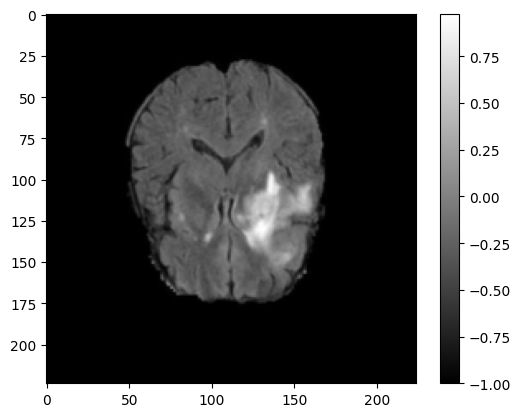

In [26]:
# analyise features of 1 image

import matplotlib.pyplot as plt

img = ds[0]["instance_images"][0] #pick arbitratry image
plt.imshow(img, cmap='gray')
plt.colorbar()
print(f'Shape of image: {img.shape}')
print(f"Range of values in the image: ({np.min(np.array(img))}, {np.max(np.array(img))})")
